In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('training_dataset.csv', delimiter =";")
# print(df.head())

In [22]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

df = df[(df['Time'] >= pd.to_datetime('06:00:00').time()) & (df['Time'] <= pd.to_datetime('09:00:00').time())]

In [23]:
# Convert 'Date' and 'Time' columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

# Create a new column 'Date_time' by combining 'Date' and 'Time'
df['Date_time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str), errors='coerce')

# Create df_new with specified features
df_new = pd.DataFrame({
    'Datetime': df['Date_time'],
    'DP_ID': df['DP_ID'],
    'Flow': df['FLOW'],
    'Avg_Speed': df['SPEED_MS_AVG'],
    'Month': df['Date'].dt.month,
    'Week': df['Date'].dt.isocalendar().week,
    'Day': df['Date'].dt.dayofweek + 1,  # Adding 1 to make Monday start from 1
    '1_Min' : df['Interval_1'],
    'Hour': df['Interval_60'] + 1,  # Adding 1 to make it start from 1
    'Half_Hour': df['Interval_30'] * 2 + 1,  # Multiplying by 2 to get half-hour and adding 1
    'Quarter': df['Interval_15'] * 4 + 1,  # Multiplying by 4 to get quarter-hour and adding 1
    '5_mins': df['Interval_5'] * 12 + 1  # Multiplying by 12 to get 5-minute intervals and adding 1
})

In [24]:
df_new.sort_values(by=['Datetime'], inplace=True, ascending=True)

In [45]:
# Sort df_new by DP_ID and Datetime
df_new_sorted = df_new.sort_values(by=['DP_ID', 'Datetime'])

# Create a function to calculate the rolling average for a given DP_ID and time window
def calculate_rolling_average(df, window_size, column_name):
    df[column_name] = df.groupby('DP_ID')['Flow'].transform(lambda x: x.rolling(window=window_size).mean())
    return df

# Create fe_df_new with specified columns
fe_df_new = pd.DataFrame({
    'DP_ID': df_new_sorted['DP_ID'],
    'Month': df_new_sorted['Month'],
    'Week': df_new_sorted['Week'],
    'Day': df['Date'].dt.dayofweek + 1,
    # 'Time': df_new_sorted['Datetime'].dt.time,
    '1_Min': df_new_sorted['1_Min'],
    'Hour': df_new_sorted['Hour'],
    'Flow': df_new_sorted['Flow'].dropna(),
    'Prev_5Min_Avg': df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=5).mean()),
    'Prev_10Min_Avg': df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=10).mean()),
    'Prev_15Min_Avg': df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=15).mean()),
    'Prev_30Min_Avg': df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=30).mean()),
    'Prev_60Min_Avg': df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=60).mean())
    
})

In [46]:
fe_df_new.isnull().sum()

DP_ID                0
Month                0
Week                 0
Day                  0
1_Min                0
Hour                 0
Flow                12
Prev_5Min_Avg      201
Prev_10Min_Avg     391
Prev_15Min_Avg     578
Prev_30Min_Avg    1133
Prev_60Min_Avg    2243
dtype: int64

In [47]:
# Fill NaN values in 'Prev_5Min_Avg' with corresponding 'Avg_Speed'
fe_df_new['Prev_5Min_Avg'] = fe_df_new['Prev_5Min_Avg'].fillna(fe_df_new['Flow'])
fe_df_new['Prev_10Min_Avg'] = fe_df_new['Prev_10Min_Avg'].fillna(fe_df_new['Flow'])
fe_df_new['Prev_15Min_Avg'] = fe_df_new['Prev_15Min_Avg'].fillna(fe_df_new['Flow'])
fe_df_new['Prev_30Min_Avg'] = fe_df_new['Prev_30Min_Avg'].fillna(fe_df_new['Flow'])
fe_df_new['Prev_60Min_Avg'] = fe_df_new['Prev_60Min_Avg'].fillna(fe_df_new['Flow'])

In [48]:
fe_df_new.dropna(subset=['Flow'], inplace=True)

In [49]:
fe_df_new.isnull().sum()

DP_ID             0
Month             0
Week              0
Day               0
1_Min             0
Hour              0
Flow              0
Prev_5Min_Avg     0
Prev_10Min_Avg    0
Prev_15Min_Avg    0
Prev_30Min_Avg    0
Prev_60Min_Avg    0
dtype: int64

In [52]:
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['1_Min', 'Month', 'Week', 'Day', 'Hour']
label_encoder = LabelEncoder()

for col in columns_to_encode:
    fe_df_new[col] = label_encoder.fit_transform(fe_df_new[col]) + 1

round_columns = ['1_Min', 'Prev_5Min_Avg', 'Prev_10Min_Avg','Prev_15Min_Avg','Prev_30Min_Avg','Prev_60Min_Avg']

fe_df_new[round_columns] = fe_df_new[round_columns].round(2)

# Assuming 'Day' column is available in fe_df_new
fe_df_new['weekend'] = fe_df_new['Day'].isin([6, 7]).astype(int)

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
#Evaluation

eval_df = pd.read_csv('final_evaluation_dataset.csv', delimiter =";")
# print(df.head())
eval_df['Time'] = pd.to_datetime(eval_df['Time'], format='%H:%M:%S').dt.time

eval_df = eval_df[(eval_df['Time'] >= pd.to_datetime('06:00:00').time()) & (df['Time'] <= pd.to_datetime('09:00:00').time())]
# # Convert 'Date' and 'Time' columns to datetime format
eval_df['Date'] = pd.to_datetime(eval_df['Date'], format='%Y%m%d')
eval_df['Time'] = pd.to_datetime(eval_df['Time'], format='%H:%M:%S').dt.time

# Create a new column 'Date_time' by combining 'Date' and 'Time'
eval_df['Date_time'] = pd.to_datetime(eval_df['Date'].astype(str) + ' ' + eval_df['Time'].astype(str), errors='coerce')

# Create df_new with specified features
eval_df_new = pd.DataFrame({
    'Datetime': eval_df['Date_time'],
    'DP_ID': eval_df['DP_ID'],
    'Flow': eval_df['FLOW'],
    'Avg_Speed': eval_df['SPEED_MS_AVG'],
    'Month': eval_df['Date'].dt.month,
    'Week': eval_df['Date'].dt.isocalendar().week,
    'Day': eval_df['Date'].dt.dayofweek + 1,  # Adding 1 to make Monday start from 1
    '1_Min' : eval_df['Interval_1'],
    'Hour': eval_df['Interval_60'] + 1,  # Adding 1 to make it start from 1
    'Half_Hour': eval_df['Interval_30'] * 2 + 1,  # Multiplying by 2 to get half-hour and adding 1
    'Quarter': eval_df['Interval_15'] * 4 + 1,  # Multiplying by 4 to get quarter-hour and adding 1
    '5_mins': eval_df['Interval_5'] * 12 + 1  # Multiplying by 12 to get 5-minute intervals and adding 1
})
eval_df_new.sort_values(by=['Datetime'], inplace=True, ascending=True)
eval_df_new.reset_index(drop=True, inplace=True)
# Sort df_new by DP_ID and Datetime
eval_df_new_sorted = eval_df_new.sort_values(by=['DP_ID', 'Datetime'])

# Create a function to calculate the rolling average for a given DP_ID and time window
def calculate_rolling_average(df, window_size, column_name):
    df[column_name] = df.groupby('DP_ID')['Flow'].transform(lambda x: x.rolling(window=window_size).mean())
    return df

# Create fe_df_new with specified columns
eval_fe_df_new = pd.DataFrame({
    'DP_ID': eval_df_new_sorted['DP_ID'],
    'Month': eval_df_new_sorted['Month'],
    'Week': eval_df_new_sorted['Week'],
    'Day': eval_df_new_sorted['Datetime'].dt.dayofweek + 1,
    'Hour': eval_df_new_sorted['Hour'],
    'Flow': eval_df_new_sorted['Flow'],
    # 'Time': df_new_sorted['Datetime'].dt.time,
    '1_Min': eval_df_new_sorted['1_Min'],
    'Avg_Speed': eval_df_new_sorted['Avg_Speed'],
    'Prev_5Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=5).mean()),
    'Prev_10Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=10).mean()),
    'Prev_15Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=15).mean()),
    'Prev_30Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=30).mean()),
    'Prev_60Min_Avg': eval_df_new_sorted.groupby('DP_ID')['Flow'].transform(lambda x: x.shift(1).rolling(window=60).mean())
})
eval_fe_df_new.reset_index(drop=True, inplace=True)
# Fill NaN values in 'Prev_5Min_Avg' with corresponding 'Avg_Speed'
eval_fe_df_new['Prev_5Min_Avg'] = eval_fe_df_new['Prev_5Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_10Min_Avg'] = eval_fe_df_new['Prev_10Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_15Min_Avg'] = eval_fe_df_new['Prev_15Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_30Min_Avg'] = eval_fe_df_new['Prev_30Min_Avg'].fillna(eval_fe_df_new['Flow'])
eval_fe_df_new['Prev_60Min_Avg'] = eval_fe_df_new['Prev_60Min_Avg'].fillna(eval_fe_df_new['Flow'])
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['1_Min', 'Month', 'Week', 'Day', 'Hour']
label_encoder = LabelEncoder()

for col in columns_to_encode:
    eval_fe_df_new[col] = label_encoder.fit_transform(eval_fe_df_new[col]) + 1

round_columns = ['1_Min', 'Prev_5Min_Avg', 'Prev_10Min_Avg','Prev_15Min_Avg','Prev_30Min_Avg','Prev_60Min_Avg']

eval_fe_df_new[round_columns] = eval_fe_df_new[round_columns].round(2)
# Assuming 'Day' column is available in fe_df_new
eval_fe_df_new['weekend'] = eval_fe_df_new['Day'].isin([6, 7]).astype(int)

eval_fe_df_new

C:\Users\stein\AppData\Local\Temp\ipykernel_14004\1830606366.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eval_df = eval_df[(eval_df['Time'] >= pd.to_datetime('06:00:00').time()) & (df['Time'] <= pd.to_datetime('09:00:00').time())]
C:\Users\stein\AppData\Local\Temp\ipykernel_14004\1830606366.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df['Date'] = pd.to_datetime(eval_df['Date'], format='%Y%m%d')


,DP_ID,Month,Week,Day,Hour,Flow,1_Min,Avg_Speed,Prev_5Min_Avg,Prev_10Min_Avg,Prev_15Min_Avg,Prev_30Min_Avg,Prev_60Min_Avg,weekend
0,153,1,1,3,1,9.0,9,24.59,9.0,9.0,9.00,9.00,9.00,0
1,153,1,1,3,1,4.0,10,22.83,4.0,4.0,4.00,4.00,4.00,0
2,153,1,1,3,1,10.0,11,22.60,10.0,10.0,10.00,10.00,10.00,0
3,153,1,1,3,1,11.0,12,24.57,11.0,11.0,11.00,11.00,11.00,0
4,153,1,1,3,1,6.0,13,23.92,6.0,6.0,6.00,6.00,6.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284376,4873,6,26,4,3,13.0,156,16.67,9.0,8.1,7.80,8.13,7.37,0
284377,4873,6,26,4,3,8.0,157,18.33,9.6,8.5,8.27,8.40,7.42,0
284378,4873,6,26,4,3,10.0,158,18.06,9.2,8.2,8.20,8.47,7.45,0
284379,4873,6,26,4,3,5.0,159,18.33,9.6,8.5,8.33,8.67,7.53,0


In [55]:
import math

def eval_metrics(y_test, y_pred,n,p):

    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', mean_squared_error(y_test, y_pred, squared=False))
    print('R2 Score:', r2_score(y_test, y_pred))

    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    print('Adjusted R2 Score:', adjusted_r2)
    print('explained_variance_score:', explained_variance_score(y_test, y_pred))

    return None

In [56]:
def create_time_windows(new_data, window_size):
    X, y = [], []
    for i in range(len(new_data) - window_size):
        X.append(new_data['Flow'].values[i:i+window_size])
        y.append(new_data['Flow'].values[i+window_size])
    return np.array(X), np.array(y)

In [57]:
new_data = fe_df_new.dropna()
eval_data = eval_fe_df_new.dropna()

Linear Regression 5min time window

Mean Absolute Error: 3.3996253727844694
Mean Squared Error: 18.341563153182936
Root Mean Squared Error: 4.282705120970032
R2 Score: 0.6946774230102142
Adjusted R2 Score: 0.6946720545879004
explained_variance_score: 0.6948784587353076


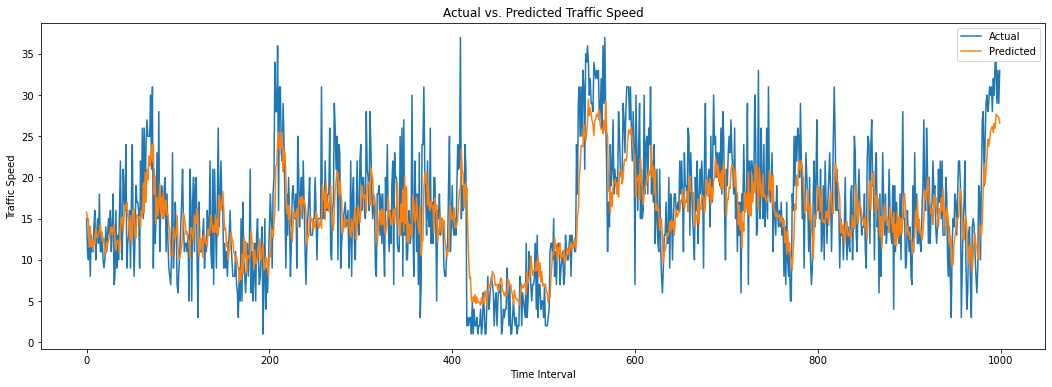

In [61]:
#set 5 min time window
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
#Linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_5m_pred = lr_model.predict(X_val_scaled)
eval_metrics(y_val, lr_5m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

15 min

Mean Absolute Error: 3.242423920554531
Mean Squared Error: 17.186054191068376
Root Mean Squared Error: 4.14560661315909
R2 Score: 0.7139170712930123
Adjusted R2 Score: 0.7139019798246737
explained_variance_score: 0.7140151565023043


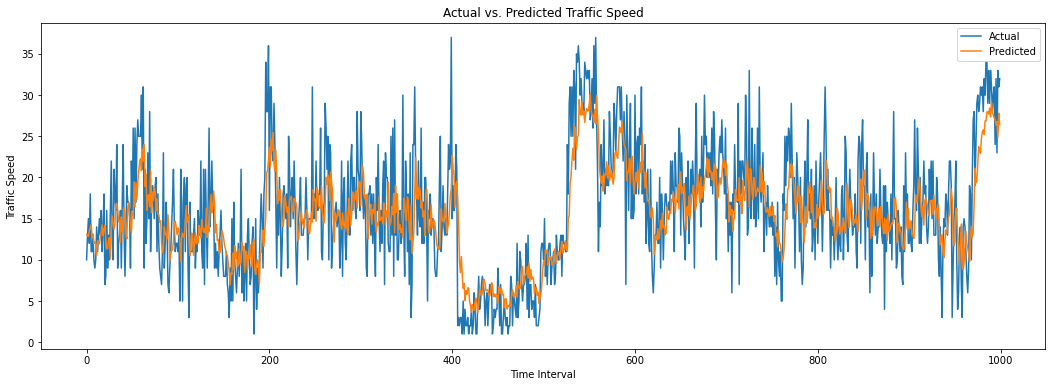

In [63]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_15m_pred = lr_model.predict(X_val_scaled)
eval_metrics(y_val, lr_15m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 3.192786466622427
Mean Squared Error: 16.905191848734223
Root Mean Squared Error: 4.111592373853982
R2 Score: 0.7186043521523809
Adjusted R2 Score: 0.7185746606107132
explained_variance_score: 0.7186582276255339


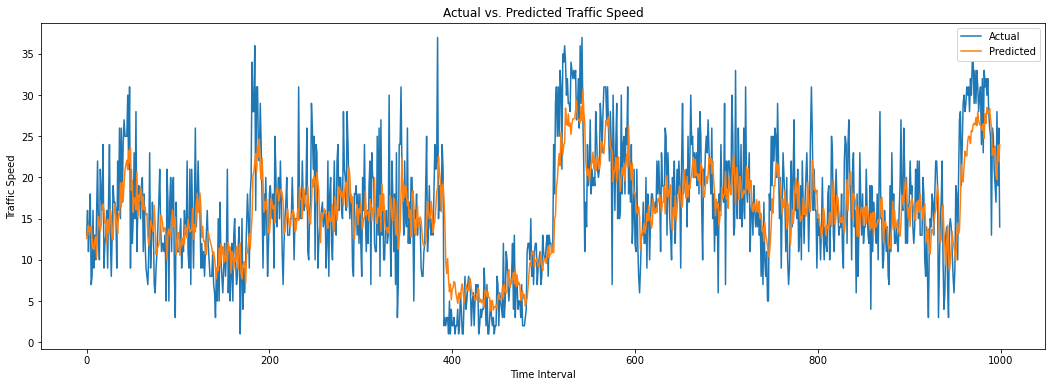

In [64]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_30m_pred = lr_model.predict(X_val_scaled)
eval_metrics(y_val, lr_30m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 3.7325282097279477
Mean Squared Error: 23.735332261426063
Root Mean Squared Error: 4.871892061758559
R2 Score: 0.6049400551647295
Adjusted R2 Score: 0.6048566678429907
explained_variance_score: 0.6049428520303857


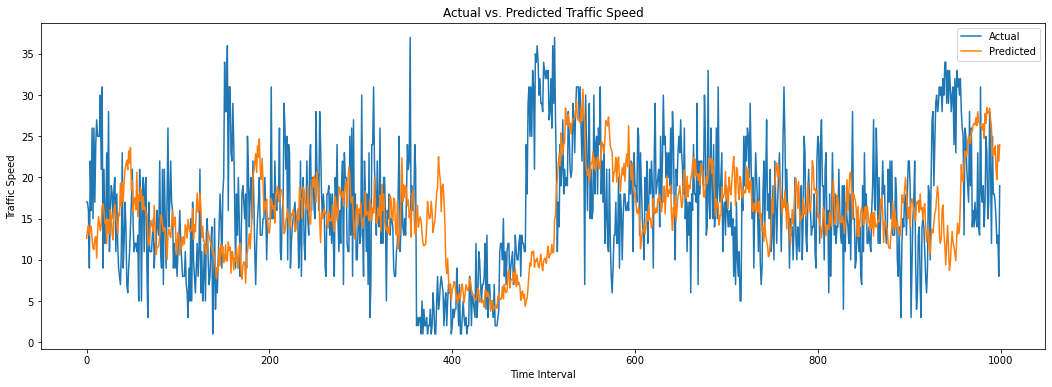

In [65]:
window_size = 60
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_60m_pred = lr_model.predict(X_val_scaled)
eval_metrics(y_val, lr_60m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(lr_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

xgBoost Regression

Mean Absolute Error: 3.5609602831075478
Mean Squared Error: 20.829613428463816
Root Mean Squared Error: 4.5639471325228795
R2 Score: 0.6532601285634715
Adjusted R2 Score: 0.6532540319096267
explained_variance_score: 0.6762168310186751


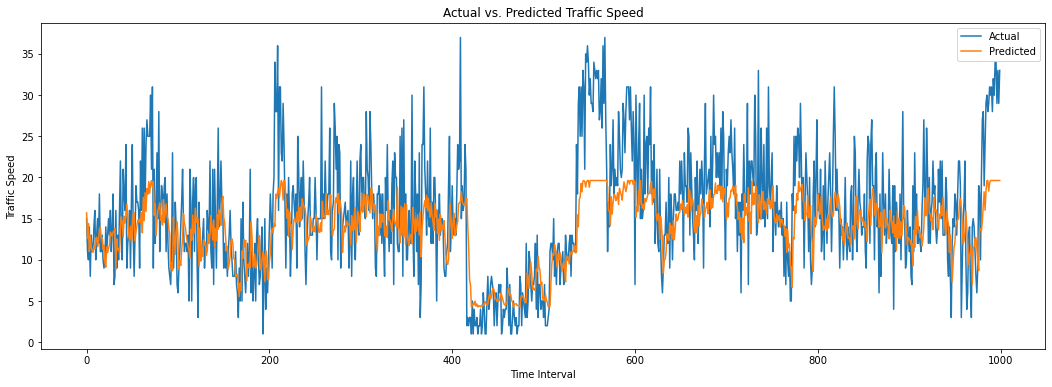

In [66]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)
xgb_5m_pred = xgb_model.predict(X_val_scaled)
eval_metrics(y_val, xgb_5m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 3.527841836371165
Mean Squared Error: 20.60022563490125
Root Mean Squared Error: 4.538747143750272
R2 Score: 0.6570840044994091
Adjusted R2 Score: 0.6570659149688234
explained_variance_score: 0.6817551565358227


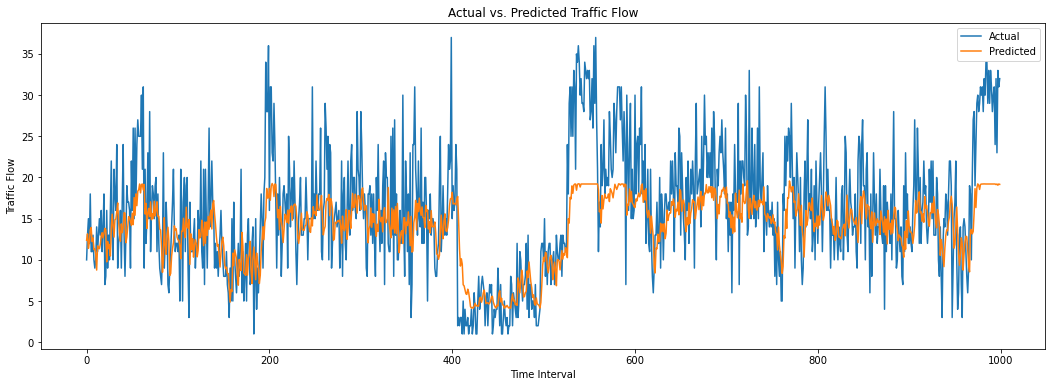

In [67]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)
xgb_15m_pred = xgb_model.predict(X_val_scaled)
eval_metrics(y_val, xgb_15m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 3.5247348928158075
Mean Squared Error: 20.5914369635466
Root Mean Squared Error: 4.537778857937725
R2 Score: 0.6572448987081766
Adjusted R2 Score: 0.6572087328063594
explained_variance_score: 0.6817328326448153


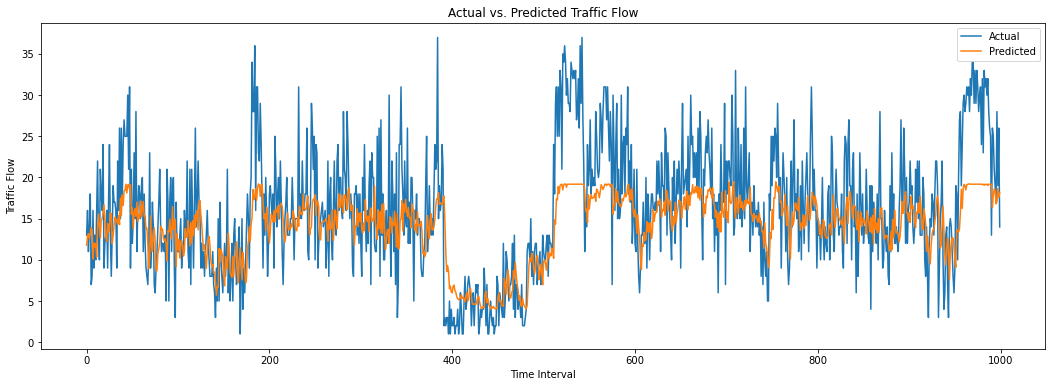

In [68]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)
xgb_30m_pred = xgb_model.predict(X_val_scaled)
eval_metrics(y_val, xgb_30m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 3.92971183190486
Mean Squared Error: 25.962236815653625
Root Mean Squared Error: 5.095315183151444
R2 Score: 0.5678746043567662
Adjusted R2 Score: 0.5677833934408811
explained_variance_score: 0.580538024900583


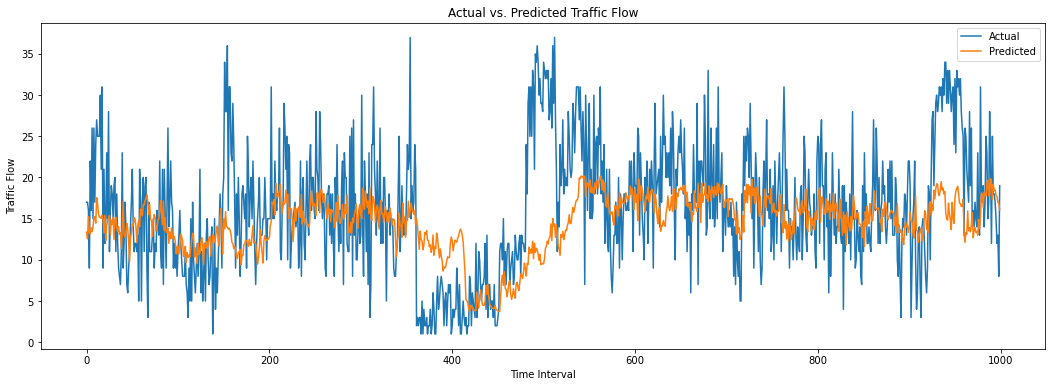

In [69]:
window_size = 60
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3)
xgb_model.fit(X_train_scaled, y_train)
xgb_60m_pred = xgb_model.predict(X_val_scaled)
eval_metrics(y_val, xgb_60m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(xgb_60m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Random Forest

In [70]:
from sklearn.ensemble import RandomForestRegressor

Mean Absolute Error: 3.826451607919225
Mean Squared Error: 23.035958459866524
Root Mean Squared Error: 4.79957898777242
R2 Score: 0.6165322365571905
Adjusted R2 Score: 0.6165254941245863
explained_variance_score: 0.6239441185626095


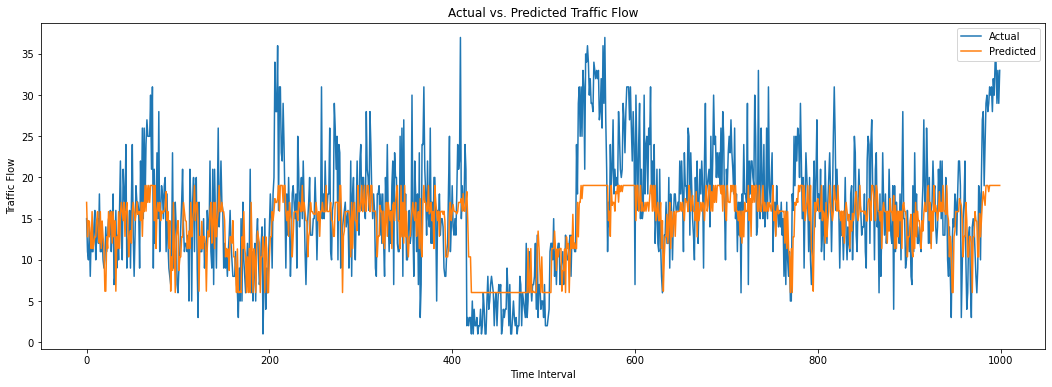

In [71]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_5m_pred = rf_model.predict(X_val_scaled)
eval_metrics(y_val, rf_5m_pred,n,p)
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 3.832244237421473
Mean Squared Error: 23.158452903861672
Root Mean Squared Error: 4.8123230257186265
R2 Score: 0.6144991772164469
Adjusted R2 Score: 0.6144788412478246
explained_variance_score: 0.6226238389269603


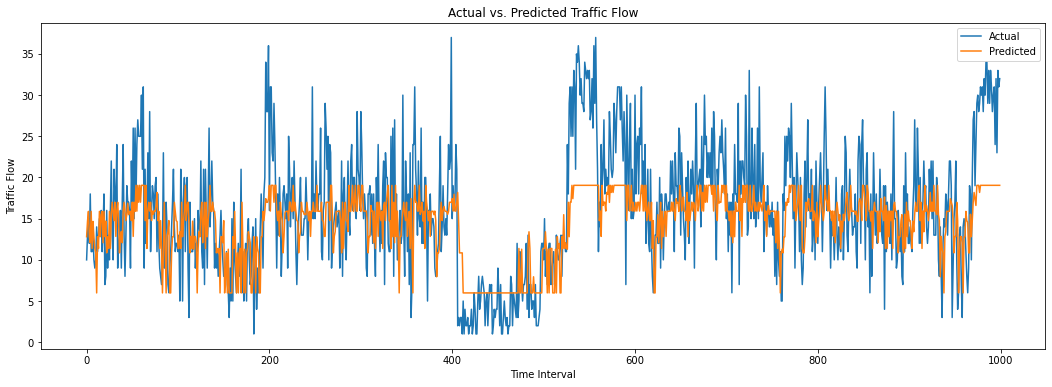

In [72]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_15m_pred = rf_model.predict(X_val_scaled)
eval_metrics(y_val, rf_15m_pred,n,p)
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 3.8347907903383014
Mean Squared Error: 23.18483417999885
Root Mean Squared Error: 4.815063258151325
R2 Score: 0.614076462858427
Adjusted R2 Score: 0.6140357420268461
explained_variance_score: 0.6221849994984079


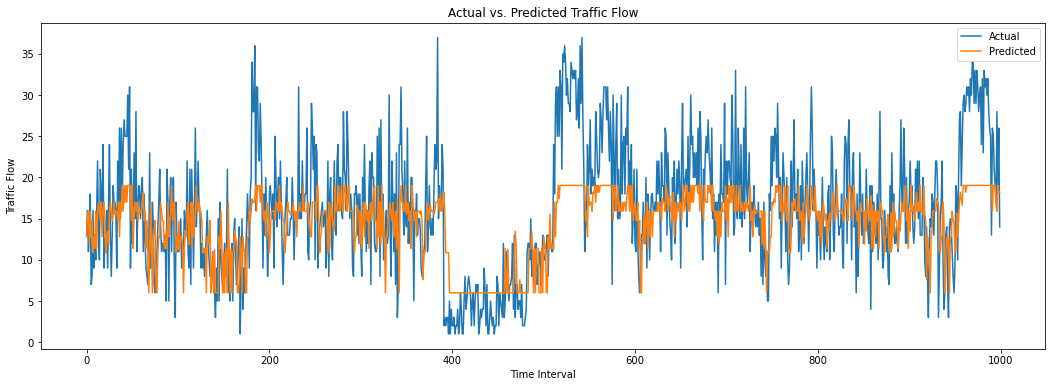

In [73]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_30m_pred = rf_model.predict(X_val_scaled)
eval_metrics(y_val, rf_30m_pred,n,p)
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Mean Absolute Error: 4.196490559241906
Mean Squared Error: 27.925925816336683
Root Mean Squared Error: 5.284498634339561
R2 Score: 0.5351902138566069
Adjusted R2 Score: 0.5350921040793665
explained_variance_score: 0.5373288611817284


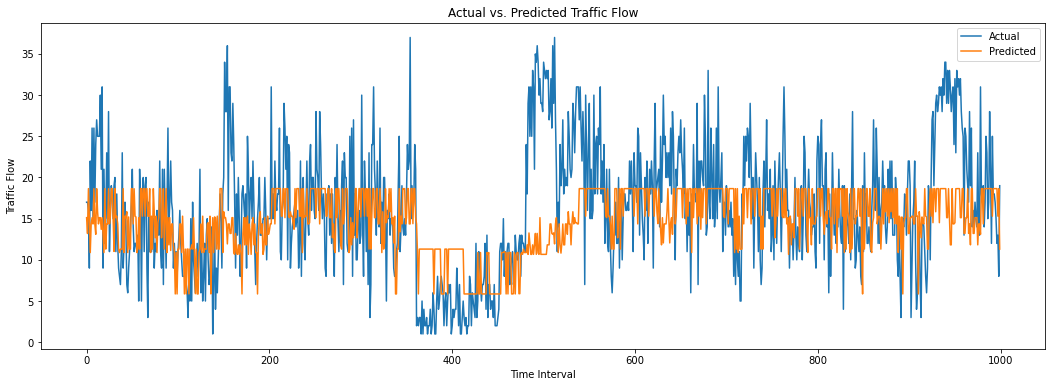

In [74]:
window_size = 60
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

rf_model = RandomForestRegressor(n_estimators=300, max_depth=3)

rf_model.fit(X_train_scaled, y_train)

rf_60m_pred = rf_model.predict(X_val_scaled)
eval_metrics(y_val, rf_60m_pred,n,p)
plt.figure(figsize=(18, 6))
start=8000
end=9000
plt.plot(y_val[start:end], label='Actual')
plt.plot(rf_60m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Vanilla LSTM

Epoch 1/20
5085/5085 [==============================] - 66s 13ms/step - loss: 45.1118 - val_loss: 18.6188
Epoch 2/20
5085/5085 [==============================] - 69s 14ms/step - loss: 38.0761 - val_loss: 18.1433
Epoch 3/20
5085/5085 [==============================] - 62s 12ms/step - loss: 36.8401 - val_loss: 18.1932
Epoch 4/20
5085/5085 [==============================] - 58s 11ms/step - loss: 36.2826 - val_loss: 19.3743
Epoch 5/20
5085/5085 [==============================] - 56s 11ms/step - loss: 36.0451 - val_loss: 18.3631
Epoch 6/20
5085/5085 [==============================] - 64s 13ms/step - loss: 35.8563 - val_loss: 17.9390
Epoch 7/20
5085/5085 [==============================] - 65s 13ms/step - loss: 35.6944 - val_loss: 19.0195
Epoch 8/20
5085/5085 [==============================] - 63s 12ms/step - loss: 35.5610 - val_loss: 18.4266
Epoch 9/20
5085/5085 [==============================] - 70s 14ms/step - loss: 35.4696 - val_loss: 18.3550
Epoch 10/20
5085/5085 [=======================

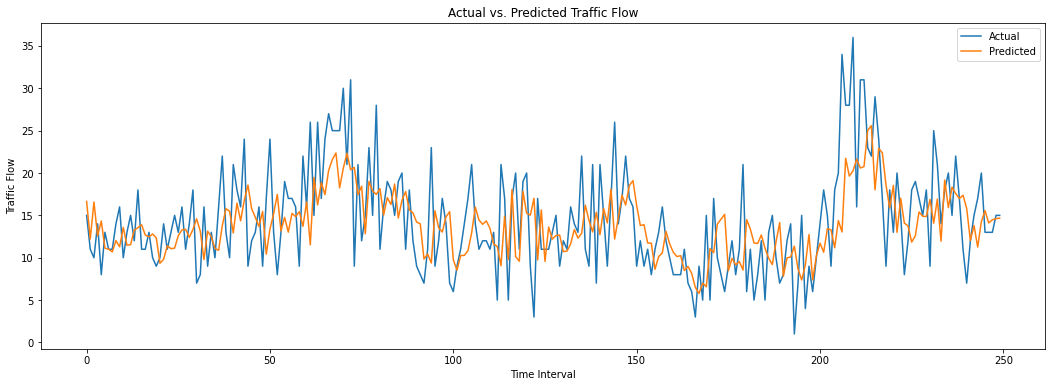

In [76]:
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

vlstm_5m_model = Sequential()
vlstm_5m_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
vlstm_5m_model.add(Dense(1))
vlstm_5m_model.compile(optimizer='adam', loss='mean_squared_error')

vlstm_5m_model.fit(X_train_scaled,y_train,epochs=20, batch_size=200, validation_data=(X_val_scaled, y_val))

vlstm_5m_pred = vlstm_5m_model.predict(X_val_scaled)
eval_metrics(y_val, vlstm_5m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Epoch 1/20
5084/5084 [==============================] - 124s 24ms/step - loss: 44.0969 - val_loss: 16.7994
Epoch 2/20
5084/5084 [==============================] - 137s 27ms/step - loss: 37.1532 - val_loss: 18.3548
Epoch 3/20
5084/5084 [==============================] - 132s 26ms/step - loss: 34.4100 - val_loss: 18.4457
Epoch 4/20
5084/5084 [==============================] - 138s 27ms/step - loss: 32.7381 - val_loss: 18.3990
Epoch 5/20
5084/5084 [==============================] - 130s 26ms/step - loss: 31.8913 - val_loss: 18.0812
Epoch 6/20
5084/5084 [==============================] - 149s 29ms/step - loss: 31.3283 - val_loss: 19.3164
Epoch 7/20
5084/5084 [==============================] - 150s 29ms/step - loss: 30.8961 - val_loss: 18.2436
Epoch 8/20
5084/5084 [==============================] - 134s 26ms/step - loss: 30.5338 - val_loss: 20.5855
Epoch 9/20
5084/5084 [==============================] - 132s 26ms/step - loss: 30.2719 - val_loss: 20.7980
Epoch 10/20
5084/5084 [==============

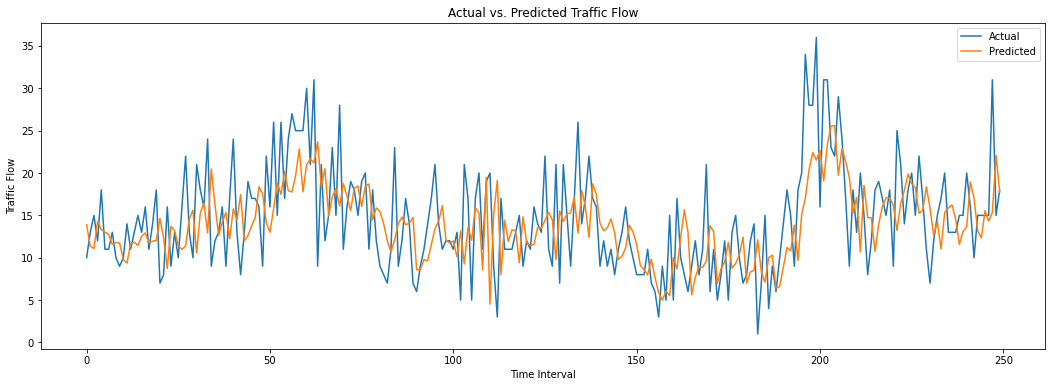

In [77]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

vlstm_15m_model = Sequential()
vlstm_15m_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
vlstm_15m_model.add(Dense(1))
vlstm_15m_model.compile(optimizer='adam', loss='mean_squared_error')

vlstm_15m_model.fit(X_train_scaled,y_train,epochs=20, batch_size=200, validation_data=(X_val_scaled, y_val))

vlstm_15m_pred = vlstm_15m_model.predict(X_val_scaled)
eval_metrics(y_val, vlstm_15m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Epoch 1/10
5084/5084 [==============================] - 293s 57ms/step - loss: 41.4452 - val_loss: 18.7234
Epoch 2/10
5084/5084 [==============================] - 295s 58ms/step - loss: 32.9562 - val_loss: 19.4583
Epoch 3/10
5084/5084 [==============================] - 284s 56ms/step - loss: 31.1066 - val_loss: 20.7600
Epoch 4/10
5084/5084 [==============================] - 297s 58ms/step - loss: 30.2227 - val_loss: 23.9116
Epoch 5/10
5084/5084 [==============================] - 291s 57ms/step - loss: 29.5256 - val_loss: 25.0236
Epoch 6/10
5084/5084 [==============================] - 307s 60ms/step - loss: 28.9071 - val_loss: 24.2910
Epoch 7/10
5084/5084 [==============================] - 302s 59ms/step - loss: 28.4224 - val_loss: 26.2889
Epoch 8/10
5084/5084 [==============================] - 300s 59ms/step - loss: 28.0364 - val_loss: 31.1261
Epoch 9/10
5084/5084 [==============================] - 313s 62ms/step - loss: 27.7601 - val_loss: 23.0842
Epoch 10/10
8886/8886 [==============

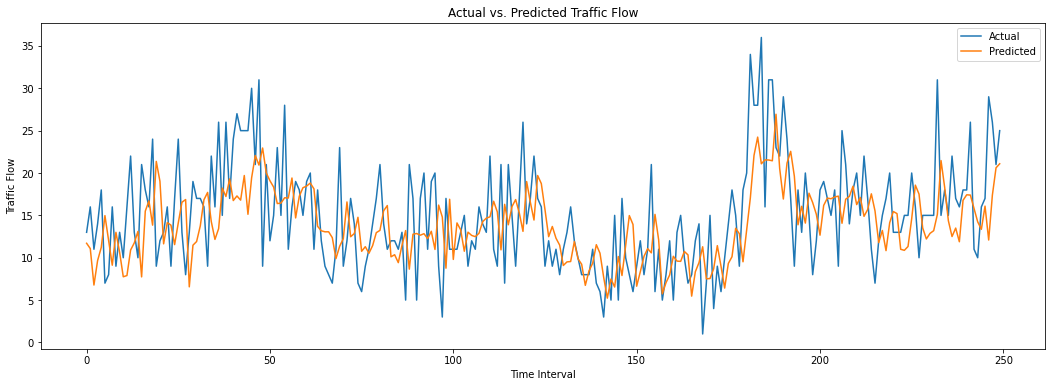

In [87]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

vlstm_30m_model = Sequential()
vlstm_30m_model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
vlstm_30m_model.add(Dense(1))
vlstm_30m_model.compile(optimizer='adam', loss='mean_squared_error')

vlstm_30m_model.fit(X_train_scaled,y_train,epochs=10, batch_size=200, validation_data=(X_val_scaled, y_val))

vlstm_30m_pred = vlstm_30m_model.predict(X_val_scaled)
eval_metrics(y_val, vlstm_30m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(vlstm_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

RNN

Epoch 1/10
5085/5085 [==============================] - 26s 5ms/step - loss: 42.1075 - val_loss: 18.2530
Epoch 2/10
5085/5085 [==============================] - 24s 5ms/step - loss: 37.1518 - val_loss: 19.0290
Epoch 3/10
5085/5085 [==============================] - 25s 5ms/step - loss: 36.6805 - val_loss: 19.3032
Epoch 4/10
5085/5085 [==============================] - 24s 5ms/step - loss: 36.3946 - val_loss: 19.5385
Epoch 5/10
5085/5085 [==============================] - 26s 5ms/step - loss: 36.1074 - val_loss: 17.8195
Epoch 6/10
5085/5085 [==============================] - 23s 5ms/step - loss: 35.8582 - val_loss: 20.0075
Epoch 7/10
5085/5085 [==============================] - 24s 5ms/step - loss: 35.6982 - val_loss: 18.9832
Epoch 8/10
5085/5085 [==============================] - 24s 5ms/step - loss: 35.5971 - val_loss: 17.8440
Epoch 9/10
5085/5085 [==============================] - 23s 5ms/step - loss: 35.5209 - val_loss: 18.0234
Epoch 10/10
8887/8887 [==============================] 

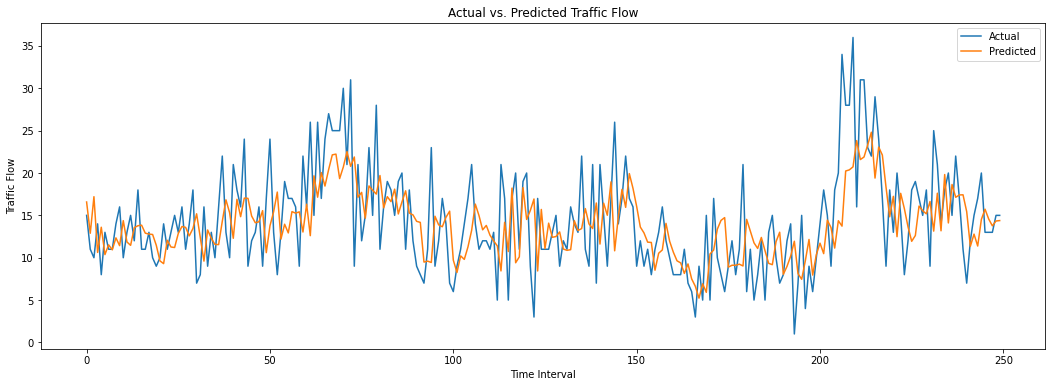

In [80]:
from tensorflow.keras.layers import SimpleRNN
window_size = 5
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

rnn_5m_model = Sequential()
rnn_5m_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
rnn_5m_model.add(Dense(1))
rnn_5m_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_5m_model.fit(X_train_scaled, y_train, epochs=10, batch_size=200, validation_data=(X_val_scaled, y_val))

rnn_5m_pred = rnn_5m_model.predict(X_val_scaled)
eval_metrics(y_val, rnn_5m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(rnn_5m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Epoch 1/10
5084/5084 [==============================] - 38s 7ms/step - loss: 39.9077 - val_loss: 17.8120
Epoch 2/10
5084/5084 [==============================] - 34s 7ms/step - loss: 34.4788 - val_loss: 18.1578
Epoch 3/10
5084/5084 [==============================] - 35s 7ms/step - loss: 33.1259 - val_loss: 17.6551
Epoch 4/10
5084/5084 [==============================] - 35s 7ms/step - loss: 32.3281 - val_loss: 18.7260
Epoch 5/10
5084/5084 [==============================] - 37s 7ms/step - loss: 31.8218 - val_loss: 20.0143
Epoch 6/10
5084/5084 [==============================] - 35s 7ms/step - loss: 31.4940 - val_loss: 18.1539
Epoch 7/10
5084/5084 [==============================] - 36s 7ms/step - loss: 31.2622 - val_loss: 18.5499
Epoch 8/10
5084/5084 [==============================] - 35s 7ms/step - loss: 31.0501 - val_loss: 17.8209
Epoch 9/10
5084/5084 [==============================] - 34s 7ms/step - loss: 30.9041 - val_loss: 18.4593
Epoch 10/10
8887/8887 [==============================] 

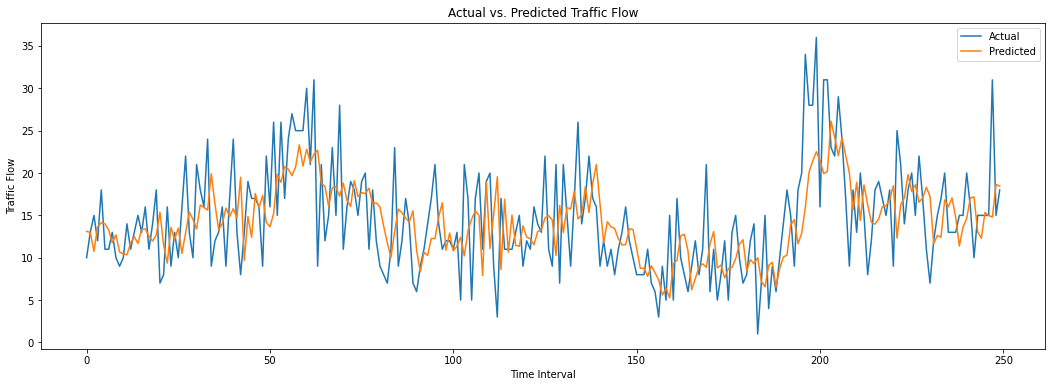

In [81]:
window_size = 15
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

rnn_15m_model = Sequential()
rnn_15m_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
rnn_15m_model.add(Dense(1))
rnn_15m_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_15m_model.fit(X_train_scaled, y_train, epochs=10, batch_size=200, validation_data=(X_val_scaled, y_val))

rnn_15m_pred = rnn_15m_model.predict(X_val_scaled)
eval_metrics(y_val, rnn_15m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(rnn_15m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()

Epoch 1/10
5084/5084 [==============================] - 57s 11ms/step - loss: 42.3084 - val_loss: 21.2031
Epoch 2/10
5084/5084 [==============================] - 54s 11ms/step - loss: 34.6088 - val_loss: 18.0864
Epoch 3/10
5084/5084 [==============================] - 55s 11ms/step - loss: 32.5078 - val_loss: 19.0985
Epoch 4/10
5084/5084 [==============================] - 56s 11ms/step - loss: 31.7639 - val_loss: 18.4500
Epoch 5/10
5084/5084 [==============================] - 56s 11ms/step - loss: 31.1742 - val_loss: 19.5454
Epoch 6/10
5084/5084 [==============================] - 54s 11ms/step - loss: 30.7366 - val_loss: 22.5551
Epoch 7/10
5084/5084 [==============================] - 54s 11ms/step - loss: 30.3563 - val_loss: 19.5884
Epoch 8/10
5084/5084 [==============================] - 55s 11ms/step - loss: 30.0213 - val_loss: 20.2702
Epoch 9/10
5084/5084 [==============================] - 56s 11ms/step - loss: 29.7799 - val_loss: 18.6394
Epoch 10/10
8886/8886 [=======================

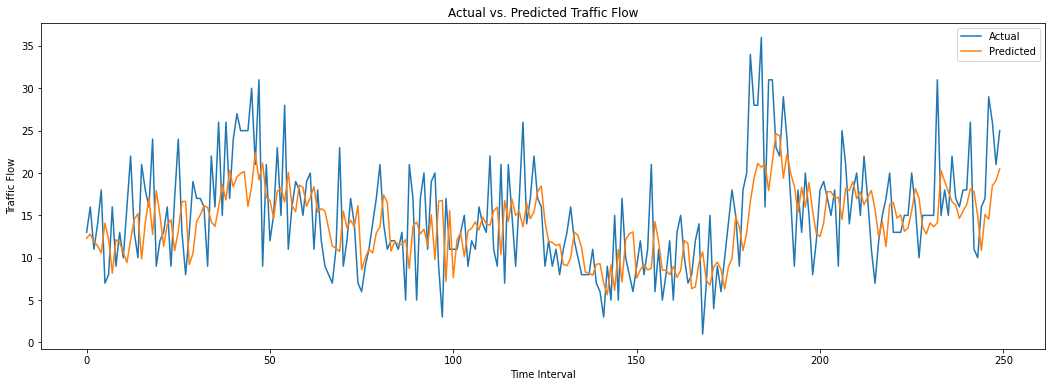

In [82]:
window_size = 30
X_train,y_train = create_time_windows(new_data, window_size)
X_val,y_val = create_time_windows(eval_data, window_size)

# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
n = len(y_val)
p = X_val_scaled.shape[1]

rnn_30m_model = Sequential()
rnn_30m_model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
rnn_30m_model.add(Dense(1))
rnn_30m_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_30m_model.fit(X_train_scaled, y_train, epochs=10, batch_size=200, validation_data=(X_val_scaled, y_val))

rnn_30m_pred = rnn_30m_model.predict(X_val_scaled)
eval_metrics(y_val, rnn_30m_pred,n,p)

plt.figure(figsize=(18, 6))
start=8000
end=8250
plt.plot(y_val[start:end], label='Actual')
plt.plot(rnn_30m_pred[start:end], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted Traffic Flow')
plt.xlabel('Time Interval')
plt.ylabel('Traffic Flow')
plt.show()